訓練集形狀: (30162, 56)
測試集形狀: (15059, 56)
特徵維度 - 訓練集: (30162, 55), 測試集: (15059, 55)
標籤分布 - 訓練集: [22654  7508], 測試集: [11359  3700]
✅ C5.0 結果讀取成功
訓練 ID3 模型中...
訓練 CART 模型中...
訓練 C4.5 模型中...

📊 所有模型準確率比較

訓練集分類正確率：
ID3     : 0.8967
CART    : 0.9749
C4.5    : 0.8829
C5.0    : 0.8725

測試集分類正確率：
ID3     : 0.8421
CART    : 0.8159
C4.5    : 0.8458
C5.0    : 0.8647

✅ 已生成結果檔：adult_test_predictions.xlsx

📋 各模型詳細分類報告

=== ID3 ===
              precision    recall  f1-score   support

       <=50K     0.8762    0.9207    0.8979     11359
        >50K     0.7116    0.6008    0.6515      3700

    accuracy                         0.8421     15059
   macro avg     0.7939    0.7607    0.7747     15059
weighted avg     0.8358    0.8421    0.8374     15059


=== CART ===
              precision    recall  f1-score   support

       <=50K     0.8752    0.8816    0.8784     11359
        >50K     0.6281    0.6141    0.6210      3700

    accuracy                         0.8159     15059
   macro avg     0.751

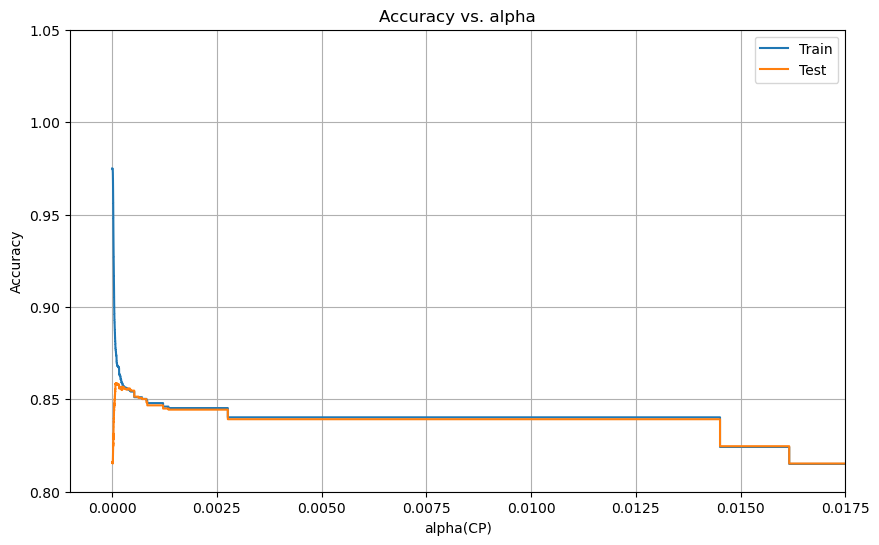


比較三種剪枝參數的決策樹

--- 1. (overfitting) ---
使用 Alpha: 0.0
樹深度 (Depth): 46
節點數 (Node Count): 10719
訓練集準確率: 0.9749
測試集準確率: 0.8159


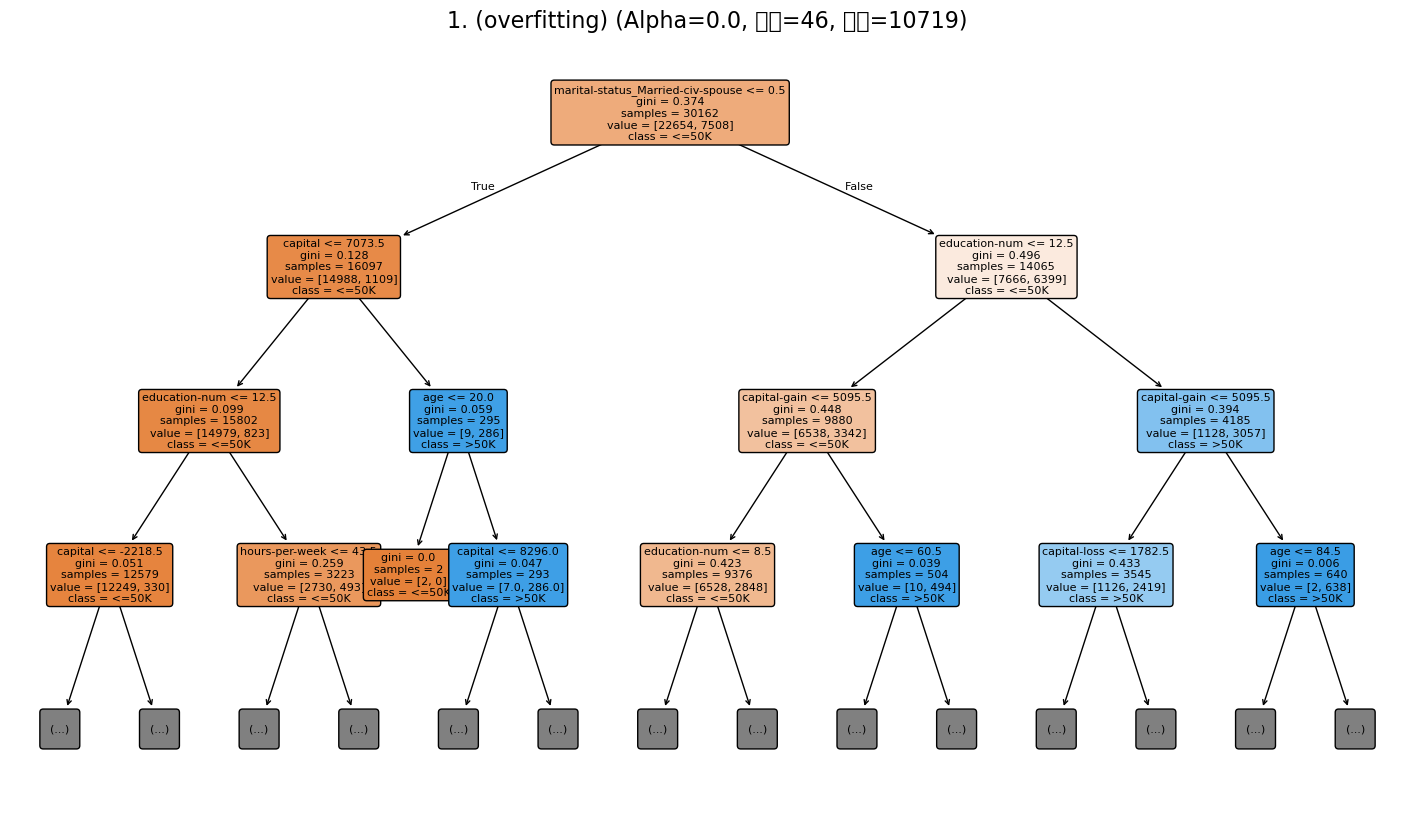


--- 2. (underfitting) ---
使用 Alpha: 0.0175
樹深度 (Depth): 2
節點數 (Node Count): 5
訓練集準確率: 0.8150
測試集準確率: 0.8153


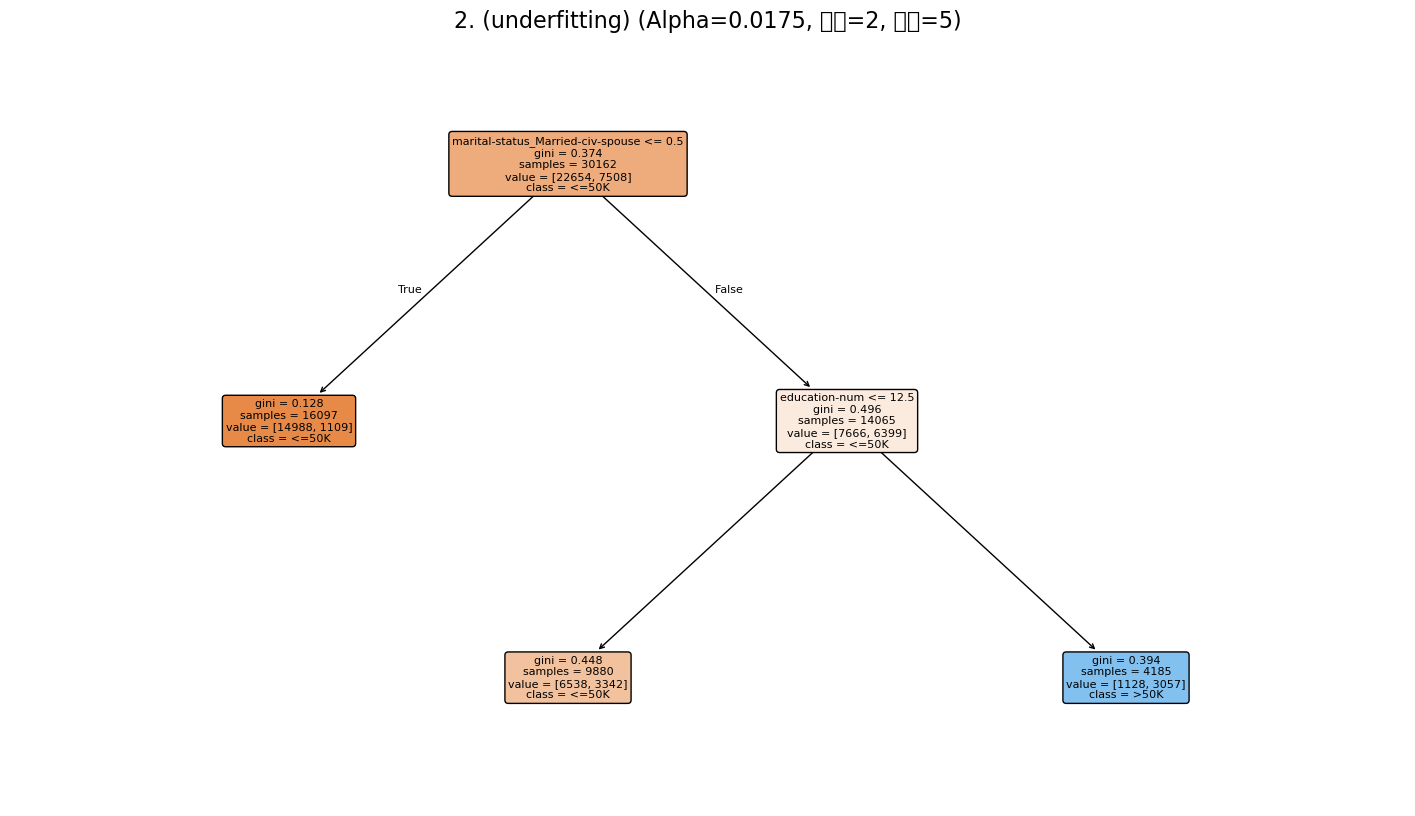


--- 3. (The Best alpha) ---
使用 Alpha: 0.00015
樹深度 (Depth): 20
節點數 (Node Count): 187
訓練集準確率: 0.8676
測試集準確率: 0.8582


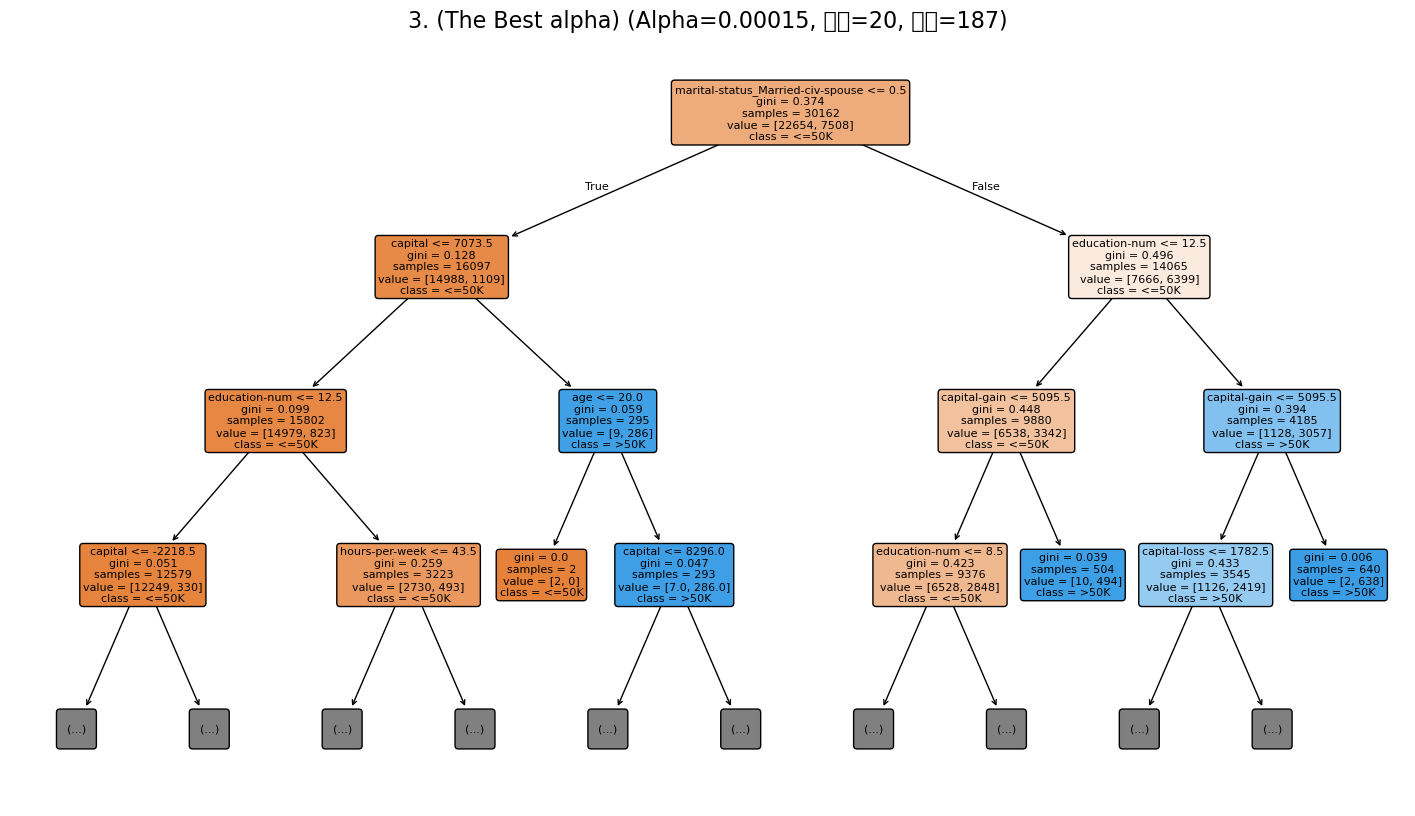

In [2]:
# ---1.匯入所需套件---
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import six
import sys
sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator

# ---------- 2. 讀取已處理的資料 ----------

def load_processed_data(train_path="processed_data/adult_train.csv", test_path="processed_data/adult_test.csv"):
    """
    直接讀取已經預處理好的資料
    """
    # 讀取訓練與測試集
    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)
    
    print(f"訓練集形狀: {df_train.shape}")
    print(f"測試集形狀: {df_test.shape}")
    
    return df_train, df_test

# ---------- 3. 準備特徵和標籤 ----------

def prepare_data(df_train, df_test):
    """
    從已處理的資料中分離特徵和標籤
    """
    # 分離特徵和標籤
    X_train = df_train.drop(columns=['income'])
    y_train = df_train['income']
    X_test = df_test.drop(columns=['income'])
    y_test = df_test['income']
    
    print(f"特徵維度 - 訓練集: {X_train.shape}, 測試集: {X_test.shape}")
    print(f"標籤分布 - 訓練集: {np.bincount(y_train)}, 測試集: {np.bincount(y_test)}")
    
    return X_train, X_test, y_train, y_test

# ---------- 4. 讀取 C5.0 結果 ----------

def load_c50_results(y_test):
    """
    讀取 C5.0 的結果檔案（程式2版本）
    """
    try:
        # 讀取預測結果
        c50_results_df = pd.read_csv("c50_result.csv")
        c50_pred = c50_results_df['predicted'].values
        
        # 讀取評估指標
        c50_metrics_df = pd.read_csv("c50_metrics.csv")
        metrics_dict = dict(zip(c50_metrics_df['metric'], c50_metrics_df['value']))
        
        print("✅ C5.0 結果讀取成功")
        return c50_pred, metrics_dict
        
    except Exception as e:
        print(f"❌ 讀取 C5.0 結果時發生錯誤: {e}")
        return None, {}

# ---------- 5. 模型訓練與比較 ----------

def train_models(X_train, X_test, y_train, y_test):
    models = {}
    train_results = {}  # 儲存訓練集準確度
    test_results = {}   # 儲存測試集準確度

    # ID3 (Entropy)
    print("訓練 ID3 模型中...")
    id3 = Id3Estimator()
    id3.fit(X_train, y_train)
    pred_id3_train = id3.predict(X_train)       # 預測訓練集
    pred_id3_test = id3.predict(X_test)         # 預測測試集
    models['ID3'] = (id3, pred_id3_test)        
    train_results['ID3'] = accuracy_score(y_train, pred_id3_train)  
    test_results['ID3'] = accuracy_score(y_test, pred_id3_test)    

    # CART (Gini)
    print("訓練 CART 模型中...")
    cart = DecisionTreeClassifier(criterion='gini', random_state=42)
    cart.fit(X_train, y_train)
    pred_cart_train = cart.predict(X_train)     # 預測訓練集
    pred_cart_test = cart.predict(X_test)       # 預測測試集
    models['CART'] = (cart, pred_cart_test)    
    train_results['CART'] = accuracy_score(y_train, pred_cart_train)  
    test_results['CART'] = accuracy_score(y_test, pred_cart_test)

    # C4.5 (approximate)
    print("訓練 C4.5 模型中...")
    c45 = DecisionTreeClassifier(
        criterion='entropy', min_samples_leaf=10, random_state=42)
    c45.fit(X_train, y_train)
    pred_c45_train = c45.predict(X_train)       # 預測訓練集
    pred_c45_test = c45.predict(X_test)         # 預測測試集
    models['C4.5'] = (c45, pred_c45_test)      
    train_results['C4.5'] = accuracy_score(y_train, pred_c45_train)  
    test_results['C4.5'] = accuracy_score(y_test, pred_c45_test)    

    return models, train_results, test_results

# ---------- 6. 輸出 Excel ----------

def export_excel(X_test, y_test, models, c50_pred=None, filename="adult_test_predictions.xlsx"):
    """
    輸出預測結果到 Excel
    """
    out = X_test.copy().reset_index(drop=True)
    out['True_Label'] = y_test.reset_index(drop=True)

    # 將數值標籤轉換回原始標籤名稱
    label_mapping = {0: '<=50K', 1: '>50K'}
    out['True_Label_Name'] = out['True_Label'].map(label_mapping)

    for name, (model, y_pred) in models.items():
        out[f"Pred_{name}"] = y_pred
        out[f"Pred_{name}_Name"] = out[f"Pred_{name}"].map(label_mapping)
    
    # 添加 C5.0 預測結果
    if c50_pred is not None:
        out['Pred_C5.0'] = c50_pred
        out['Pred_C5.0_Name'] = out['Pred_C5.0'].map(label_mapping)

    out.to_excel(filename, index=False)
    print(f"\n✅ 已生成結果檔：{filename}")
    
    return out

# ---------- 7. 成本複雜度剪枝 (CCP) 函式 ----------
def perform_cost_complexity_pruning(X_train, X_test, y_train, y_test):
    
    # === 第 1 步：計算剪枝路徑 ===
    base_clf = DecisionTreeClassifier(criterion='gini', random_state=42)
    
    # 找出適用於 "Adult" 資料集的剪枝路徑
    path = base_clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas = path.ccp_alphas
    
    # 移除 alpha < 0 的情況
    ccp_alphas = ccp_alphas[ccp_alphas >= 0]
    print(f"總共找到了 {len(ccp_alphas)} 個不同的 alpha 轉折點。")

    # === 第 2 步：訓練所有剪枝後的樹 ===
    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = DecisionTreeClassifier(criterion='gini', random_state=42, ccp_alpha=ccp_alpha)
        clf.fit(X_train, y_train)
        clfs.append(clf)
    print("所有剪枝後的樹都已訓練完畢。")

    # === 第 3 步：畫出「準確率 vs. Alpha」圖 ===
    clfs = clfs[:-1]
    ccp_alphas = ccp_alphas[:-1]

    train_scores = [clf.score(X_train, y_train) for clf in clfs]
    test_scores = [clf.score(X_test, y_test) for clf in clfs]

    plt.figure(figsize=(10, 6))
    plt.xlim(-0.001, 0.0175)
    plt.ylim(0.8, 1.05)
    plt.xlabel("alpha(CP)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. alpha")
    plt.plot(ccp_alphas, train_scores, label="Train", drawstyle="steps-post")
    plt.plot(ccp_alphas, test_scores, label="Test", drawstyle="steps-post")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # === 第 4 步：選擇 3 個 Alpha 並比較 ===
    # 取得特徵名稱
    feature_names = X_train.columns.tolist()
    
    # 類別名稱
    class_names = ['<=50K', '>50K']
    
    # Alpha 值設定（根據圖形調整）
    alphas_to_plot = {
        "1. (Overfitting)": 0.0000, 
        "2. (Underfitting)": 0.0175, 
        "3. (The Best alpha)": 0.00015  
    }

    print("\n" + "="*50)
    print("比較三種剪枝參數的決策樹")
    print("="*50)

    for name, alpha in alphas_to_plot.items():
        clf_final = DecisionTreeClassifier(criterion='gini', random_state=42, ccp_alpha=alpha)
        clf_final.fit(X_train, y_train)
        
        train_acc = clf_final.score(X_train, y_train)
        test_acc = clf_final.score(X_test, y_test)
        node_count = clf_final.tree_.node_count
        depth = clf_final.tree_.max_depth
        
        print(f"\n--- {name} ---")
        print(f"使用 Alpha: {alpha}")
        print(f"樹深度 (Depth): {depth}")
        print(f"節點數 (Node Count): {node_count}")
        print(f"訓練集準確率: {train_acc:.4f}")
        print(f"測試集準確率: {test_acc:.4f}")
        
        # 畫出決策樹
        plt.figure(figsize=(18, 10))
        plot_tree(clf_final, 
                  filled=True, 
                  rounded=True, 
                  class_names=class_names,
                  feature_names=feature_names,
                  max_depth=3,  # 只畫出前3層
                  fontsize=8)
        plt.title(f"{name} (Alpha={alpha}, Depths={depth}, Nodes={node_count})", fontsize=16)
        plt.show()

# ---------- 8. 主程式 ----------

def main():
    # 載入已處理的資料
    df_train, df_test = load_processed_data("processed_data/adult_train.csv", "processed_data/adult_test.csv")
    
    # 準備特徵和標籤
    X_train, X_test, y_train, y_test = prepare_data(df_train, df_test)
    
    # 讀取 C5.0 結果
    c50_pred, c50_metrics = load_c50_results(y_test)
    
    # 訓練 Python 模型
    models, train_results, test_results = train_models(X_train, X_test, y_train, y_test)
    
    # 將 C5.0 結果加入到結果中
    if c50_metrics:
        train_results['C5.0'] = c50_metrics.get('train_accuracy', 0)
        test_results['C5.0'] = c50_metrics.get('accuracy', 0)
    
    # 顯示所有模型結果
    print("\n" + "="*50)
    print("📊 所有模型準確率比較")
    print("="*50)
    
    print("\n訓練集分類正確率：")
    for name, acc in train_results.items():
        print(f"{name:8s}: {acc:.4f}")
        
    print("\n測試集分類正確率：")
    for name, acc in test_results.items():
        print(f"{name:8s}: {acc:.4f}")

    # 輸出 Excel（包含 C5.0 結果）
    result_df = export_excel(X_test, y_test, models, c50_pred)

    # 顯示各模型詳細報告
    print("\n" + "="*50)
    print("📋 各模型詳細分類報告")
    print("="*50)
    
    # Python 模型的詳細報告
    for name, (model, pred) in models.items():
        print(f"\n=== {name} ===")
        print(classification_report(y_test, pred, target_names=['<=50K', '>50K'], digits=4))
    
    # C5.0 的詳細報告（與其他演算法相同格式）
    if c50_pred is not None:
        print(f"\n=== C5.0 ===")
        print(classification_report(y_test, c50_pred, target_names=['<=50K', '>50K'], digits=4))

    # 執行成本複雜度剪枝
    print("\n" + "="*50)
    print("執行成本複雜度剪枝 (Cost Complexity Pruning)")
    print("="*50)
    perform_cost_complexity_pruning(X_train, X_test, y_train, y_test)

if __name__ == "__main__":
    main()